Test the function for training guassian process regression

In [352]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, dw_gen, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster
from sklearn.utils import check_random_state
import modelval.gp_regressor

import warnings

warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [353]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60


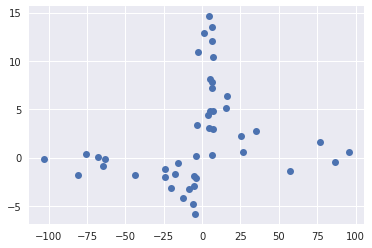

In [354]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]

# Seperate the data into training and validation
from sklearn.model_selection import KFold

x = data1['dt1'].reshape(-1,1)
y = data1['dw_mean'].reshape(-1,1)

# Rescale y to match the maximum variance of RBF kernel during Gaussian Process Regression

y = y/data1[np.abs(data1['dt1'])>50]['dw_mean'].std()
plt.plot(x,y,'o')

In [356]:
# Hyperparameter search
# Create the parameter list
param_list={
   # 'scale': np.linspace(20,60,5),              # scaler for baseline variance
   # 'noise_const': np.linspace(50,120,10),      # Dependence of noise on |x|
    'sigma_obs': np.linspace(0.05,1,20),          # Noise variance
    'bias': np.linspace(5,15,15),                # Mimimum length scale
    'sigma_kernel': np.linspace(0.05,1,20),      # length scale for covariance matrix
}

# Convert to parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = list(ParameterGrid(param_list))
kf = KFold(n_splits=5, shuffle=True)
# Perform k-fold cross validation and get mean mse
mse = np.zeros(len(param_grid))
for i in range(len(param_grid)):
    k = 0
    for train_index, test_index in kf.split(x):
        mse_tmp = np.ones(kf.get_n_splits(x)) * np.nan
        x_train = x[train_index,:].reshape(-1,1)
        y_train = y[train_index,:].reshape(-1,1)
        x_test = x[test_index,:].reshape(-1,1)
        y_test = y[test_index,:].reshape(-1,1)
        gp_rg=gp_regressor.GP_regressor(x_train, y_train, x_test, if_stat_kernel=False, **param_grid[i])
        try:
            gp_rg.fit(y_bias=0)
        except:
            continue
        f, _, _ = gp_rg.fit(y_bias=0)
        mse_tmp[k] = np.nanmean(np.square(f-y_test))
        k = k+1
    mse[i] = np.nanmean(mse_tmp)

In [357]:
# Choose the parameter with minimum mse
param_best = param_grid[np.where(mse == np.nanmin(mse))[0][0]]
param_best = {'bias': 7.8571428571428577,
 'sigma_kernel': 0.54999999999999993,
 'sigma_obs': 0.90000000000000002}

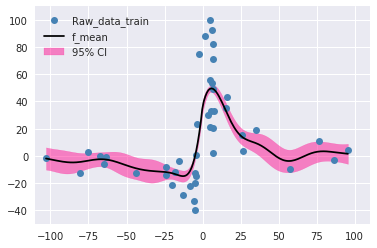

In [396]:
x = data1['dt1'].reshape(-1,1)
y = data1['dw_mean'].reshape(-1,1)
y = y/data1[np.abs(data1['dt1'])>50]['dw_mean'].std()
x_test = np.linspace(np.min(x),np.max(x),200).reshape(-1,1)
#param_best = {'bias': 10, 'sigma_kernel': 0.05, 'sigma_obs':1}
# Create gp regressor with designated parameter
gp_rg = gp_regressor.GP_regressor(x, y, x_test,if_stat_kernel=False, **param_best)
f, v_f, lp = gp_rg.fit(y_bias=0)
f = f*data1[np.abs(data1['dt1'])>50]['dw_mean'].std()
std = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)*data1[np.abs(data1['dt1'])>50]['dw_mean'].std()
plt.plot(data1['dt1'], data1['dw_mean'],'o', color='steelblue',label='Raw_data_train')
plt.plot(x_test, f, 'k', label='f_mean')
plt.axis([-110,110,-50,110])
plt.fill_between(np.squeeze(x_test), np.squeeze(f-1.96*std), np.squeeze(f+1.96*std), alpha=0.5, color='deeppink', label='95% CI')
plt.legend(loc='upper left')

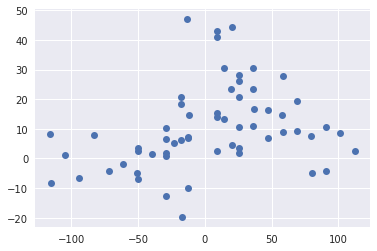

In [376]:
# Generate data for Quadruplet protocol
data3 = data[data['ptl_idx']==3]
plt.plot(data3['dt2'], data3['dw_mean'],'o', label='Raw_data_train')

In [337]:
# Hyperparameter search

# Create the parameter list
param_list={
   # 'scale': np.linspace(20,60,5),              # scaler for baseline variance
   # 'noise_const': np.linspace(50,120,10),      # Dependence of noise on |x|
    'sigma_obs': np.linspace(0.05,1,20),          # Noise variance
    'bias': np.linspace(5,15,15),                # Mimimum length scale
    'sigma_kernel': np.linspace(0.05,1,20),      # length scale for covariance matrix
}

# Convert to parameter grid
from sklearn.model_selection import ParameterGrid
param_grid = list(ParameterGrid(param_list))

# Seperate the data into training and validation
from sklearn.model_selection import KFold

x_r = data3[data3['dt2']>0]['dt2'].reshape(-1,1)
y_r = data3[data3['dt2']>0]['dw_mean'].reshape(-1,1)

x_l = data3[data3['dt2']<0]['dt2'].reshape(-1,1)
y_l = data3[data3['dt2']<0]['dw_mean'].reshape(-1,1)

kf = KFold(n_splits=5, shuffle=True)
# Perform k-fold cross validation and get mean mse
mse = np.zeros(len(param_grid))
for i in range(len(param_grid)):
    k = 0
    for (train_r_index, test_r_index), (train_l_index, test_l_index) in zip(kf.split(x_r),kf.split(x_l)):
        mse_tmp = np.ones(kf.get_n_splits(x_r)) * np.nan
        x_train_r = x_r[train_r_index,:].reshape(-1,1)
        x_train_l = x_l[train_l_index,:].reshape(-1,1)
        y_train_r = y_r[train_r_index,:].reshape(-1,1)
        y_train_l = y_l[train_l_index,:].reshape(-1,1)
        x_test_r = x_r[test_r_index,:].reshape(-1,1)
        y_test_r = y_r[test_r_index,:].reshape(-1,1)
        x_test_l = x_l[test_l_index,:].reshape(-1,1)
        y_test_l = y_l[test_l_index,:].reshape(-1,1)
        gp_rg_r = gp_regressor.GP_regressor(x_r, y_r, x_test_r,if_stat_kernel=False,  **param_grid[i])
        gp_rg_l = gp_regressor.GP_regressor(x_l, y_l, x_test_l,if_stat_kernel=False, **param_grid[i])
        try:
            gp_rg_r.fit()
            gp_rg_l.fit()
        except:
            continue
        f_r, _, _ = gp_rg_r.fit()
        f_l, _, _ = gp_rg_l.fit()
        mse_tmp[k] = np.nanmean(np.square(f_r-y_test_r)) + np.nanmean(np.square(f_l-y_test_l))
        k = k+1
    mse[i] = np.nanmean(mse_tmp)

In [377]:
# Choose the parameter with minimum mse
param_best = param_grid[np.where(mse == np.nanmin(mse))[0][0]]
param_best = {'bias': 6.4285714285714288,
 'sigma_kernel': 0.84999999999999998,
 'sigma_obs': 0.79999999999999993}

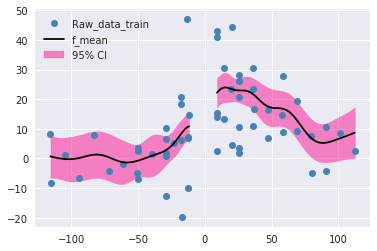

In [394]:
x_r = data3[data3['dt2']>0]['dt2'].reshape(-1,1)
y_r = data3[data3['dt2']>0]['dw_mean'].reshape(-1,1)
x_test_r = np.linspace(np.min(x_r),np.max(x_r),120).reshape(-1,1)
y_r = y_r/data3[np.abs(data3['dt2'])>100]['dw_mean'].std()

x_l = data3[data3['dt2']<0]['dt2'].reshape(-1,1)
y_l = data3[data3['dt2']<0]['dw_mean'].reshape(-1,1)
x_test_l = np.linspace(np.min(x_l),np.max(x_l),120).reshape(-1,1)
y_l = y_l/data3[np.abs(data3['dt2'])>100]['dw_mean'].std()

#best_params = {'sigma_kernel':1,'bias':5, 'sigma_obs':1, 'if_stat_kernel':False}

gp_rg = gp_regressor.GP_regressor(x_r, y_r, x_test_r, **best_params)
f, v_f_r, lp = gp_rg.fit()
f = f * data3[np.abs(data3['dt2'])>100]['dw_mean'].std()
std = np.sqrt(v_f_r.transpose().diagonal()).reshape(-1,1)* data3[np.abs(data3['dt2'])>100]['dw_mean'].std()
plt.plot(x_r, data3[data3['dt2']>0]['dw_mean'],'o', color='steelblue', label='Raw_data_train')
plt_range1 = np.arange(0,112,1)

plt.plot(x_test_r, f,'k')
plt.fill_between(np.squeeze(x_test_r), np.squeeze(f-1.96*std), np.squeeze(f+1.96*std), alpha=0.5, color='deeppink')


gp_rg = gp_regressor.GP_regressor(x_l, y_l, x_test_l, **best_params)
f, v_f_l, lp = gp_rg.fit()
f = f * data3[np.abs(data3['dt2'])>100]['dw_mean'].std()
std = np.sqrt(v_f_l.transpose().diagonal()).reshape(-1,1)* data3[np.abs(data3['dt2'])>100]['dw_mean'].std()
plt.plot(x_l, np.array(data3[data3['dt2']<0]['dw_mean']),'o',color='steelblue')
plt.plot(x_test_l, f,'k', label='f_mean')
plt.fill_between(np.squeeze(x_test_l), np.squeeze(f-1.96*std), np.squeeze(f+1.96*std), alpha=0.5, color='deeppink', label='95% CI')
plt.legend(loc='upper left')

In [217]:
param_grid[np.where(mse == np.nanmin(mse))[0][0]]

{'bias': 15.0,
 'sigma_kernel': 1.8655172413793102,
 'sigma_obs': 6.8333333333333339}

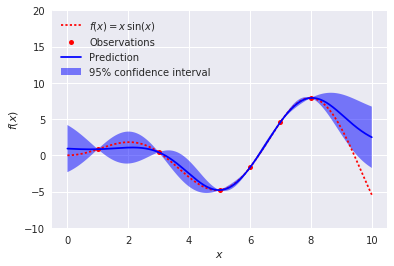

In [329]:
# Test with toy example
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).reshape(-1,1)

# Observations
y = f(X).ravel().reshape(-1,1)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_rg = gp_regressor.GP_regressor(X, y, x, sigma_obs=0, sigma_kernel=0.1)
y_pred, v_f, lp = gp_rg.fit()
sigma = np.sqrt(v_f.transpose().diagonal()).reshape(-1,1)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')

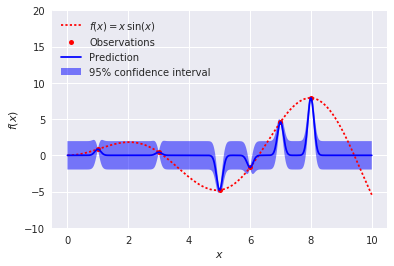

In [330]:
np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T

# Instanciate a Gaussian Process model
kernel = RBF(0.1)
gp = GaussianProcessRegressor(kernel=kernel)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(x, f(x), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
plt.plot(x, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
